In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('ggplot')

import cartopy.crs as ccrs
import cartopy.feature as cfeat
import cartopy.io.img_tiles as cimgt

In [2]:
def plot_to_map(size, longitude, latitude) :
    stamen_terrain = cimgt.StamenTerrain()
    
    plt.figure(figsize = size)
    ax = plt.axes(projection = ccrs.Mercator())
    
    min_long = longitude.min() - 0.5
    max_long = longitude.max() + 0.5
    min_lat = latitude.min() - 0.5
    max_lat = latitude.max() + 0.5
    ax.set_extent([min_long, max_long, min_lat, max_lat])
    
    #ax.add_image(stamen_terrain, 8)
    ax.add_feature(cfeat.LAND.with_scale('50m'))
    ax.add_feature(cfeat.OCEAN.with_scale('50m'))
    ax.add_feature(cfeat.COASTLINE.with_scale('50m'))
    ax.add_feature(cfeat.BORDERS.with_scale('50m'))
    ax.add_feature(cfeat.RIVERS.with_scale('50m'))
    
    ax.scatter(x = longitude, y = latitude, transform = ccrs.PlateCarree())
    
    # Draw Rotterdam marker
    ax.scatter(x = 4.47917, y = 51.9225, transform = ccrs.PlateCarree(), marker = '*', c = 'C1', s = 500)
    # Draw Hamburg marker
    ax.scatter(x = 10.01534, y = 53.57532, transform = ccrs.PlateCarree(), marker = '*', c = 'C1', s = 500)
    
    return

In [3]:
# Load the data
names = ['TripID', 'MMSI', 'StartLatitude', 'StartLongitude', 'StartTime', 'EndLatitude', 'EndLongitude', 'EndTime',
         'StartPort', 'EndPort', 'ID', 'time', 'shiptype', 'Length', 'Breadth', 'Draught', 'Latitude', 'Longitude',
         'SOG', 'COG', 'TH', 'Destination', 'Name', 'Callsign', 'AisSourcen']
ais = pd.read_csv('rotterdam_hamburg.arff', names = names, skiprows = 27, parse_dates = True, index_col = 'ID',
                  na_values = ['?'], dtype = {'TripID': str, 'MMSI': str, 'shiptype': str})

In [4]:
ais.head()

,TripID,MMSI,StartLatitude,StartLongitude,StartTime,EndLatitude,EndLongitude,EndTime,StartPort,EndPort,...,Draught,Latitude,Longitude,SOG,COG,TH,Destination,Name,Callsign,AisSourcen
ID,,,,,,,,,,,,,,,,,,,,,
39110154,21109,210481000,51.94,4.05,'2016-1-21 04:32',53.53,9.91,'2016-1-22 06:04',ROTTERDAM,HAMBURG,...,10.64,53.95,7.82,14.7,81.0,80.0,HAMBURG,CMA.CGM.SAMBHAR,5BND2,H7001.DAIS1.81b.71.71a
39112959,21109,210481000,51.94,4.05,'2016-1-21 04:32',53.53,9.91,'2016-1-22 06:04',ROTTERDAM,HAMBURG,...,10.64,53.95,7.83,14.7,80.0,80.0,HAMBURG,CMA.CGM.SAMBHAR,5BND2,H7001.DAIS1.81b.71.71a
39118599,21109,210481000,51.94,4.05,'2016-1-21 04:32',53.53,9.91,'2016-1-22 06:04',ROTTERDAM,HAMBURG,...,10.64,53.95,7.83,14.7,81.0,80.0,HAMBURG,CMA.CGM.SAMBHAR,5BND2,H7001.DAIS1.81b.71.71a
39123728,21109,210481000,51.94,4.05,'2016-1-21 04:32',53.53,9.91,'2016-1-22 06:04',ROTTERDAM,HAMBURG,...,10.64,53.95,7.84,14.7,80.0,80.0,HAMBURG,CMA.CGM.SAMBHAR,5BND2,H7001.DAIS1.81b.71.71a
39127583,21109,210481000,51.94,4.05,'2016-1-21 04:32',53.53,9.91,'2016-1-22 06:04',ROTTERDAM,HAMBURG,...,10.64,53.95,7.85,14.7,81.0,80.0,HAMBURG,CMA.CGM.SAMBHAR,5BND2,H7001.DAIS1.81b.71.71a


In [5]:
# Convert time columns to correct dtype
ais['StartTime'] = pd.to_datetime(ais['StartTime'], format = '\'%Y-%m-%d %H:%M\'')
ais['EndTime'] = pd.to_datetime(ais['EndTime'], format = '\'%Y-%m-%d %H:%M\'')
ais['time'] = pd.to_datetime(ais['time'], format = '\'%Y-%m-%d %H:%M\'')

In [6]:
# Convert all headings that are 511 (>= 360) to NaN
ais.loc[ais['TH'] >= 360, 'TH'] = np.nan

In [7]:
# Convert courses >= 360 to NaN
ais.loc[ais['COG'] >= 360, 'COG'] = np.nan

In [8]:
# Set invalid shiptypes to NaN
# Invalid shiptypes existing in the data set are '0' and '159'
ais.loc[(ais['shiptype'] == '0') | (ais['shiptype'] == '159'), 'shiptype'] = np.nan

In [9]:
# Set invalid lengths (0 or > 400) to NaN
ais.loc[(ais['Length'] <= 0) | (ais['Length'] > 400), 'Length'] = np.nan

In [10]:
ais = ais.drop(['AisSourcen', 'StartPort', 'EndPort', 'Name', 'MMSI', 'shiptype'], axis = 1)

In [11]:
ais.head()

,TripID,StartLatitude,StartLongitude,StartTime,EndLatitude,EndLongitude,EndTime,time,Length,Breadth,Draught,Latitude,Longitude,SOG,COG,TH,Destination,Callsign
ID,,,,,,,,,,,,,,,,,,
39110154,21109,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 06:04:00,2016-01-21 22:04:00,269.0,32,10.64,53.95,7.82,14.7,81.0,80.0,HAMBURG,5BND2
39112959,21109,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 06:04:00,2016-01-21 22:05:00,269.0,32,10.64,53.95,7.83,14.7,80.0,80.0,HAMBURG,5BND2
39118599,21109,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 06:04:00,2016-01-21 22:06:00,269.0,32,10.64,53.95,7.83,14.7,81.0,80.0,HAMBURG,5BND2
39123728,21109,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 06:04:00,2016-01-21 22:07:00,269.0,32,10.64,53.95,7.84,14.7,80.0,80.0,HAMBURG,5BND2
39127583,21109,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 06:04:00,2016-01-21 22:08:00,269.0,32,10.64,53.95,7.85,14.7,81.0,80.0,HAMBURG,5BND2


Text(0.5,1,u'All Positions Before Filtering')

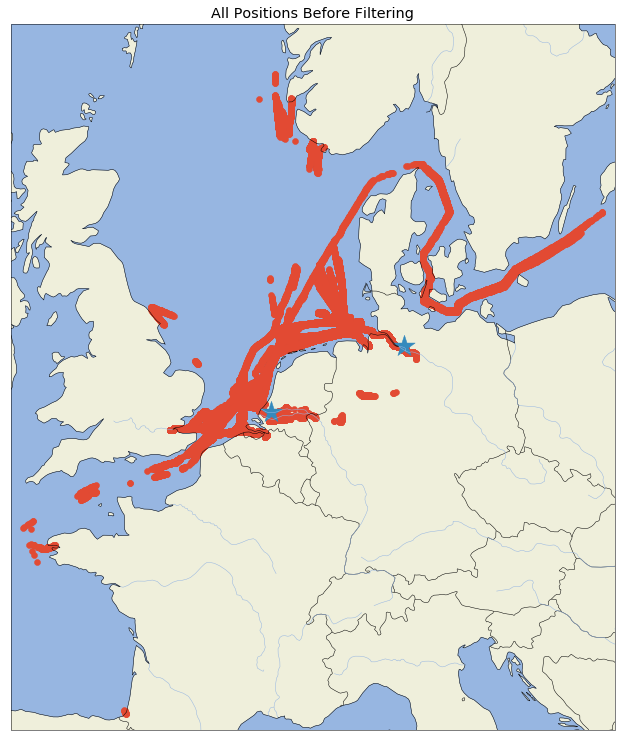

In [12]:
# Plot all positions in the data before any filters are applied
plot_to_map(size = (13, 13), longitude = ais['Longitude'], latitude = ais['Latitude'])
plt.title("All Positions Before Filtering")

Text(0.5,1,u'Start Positions Before Filtering')

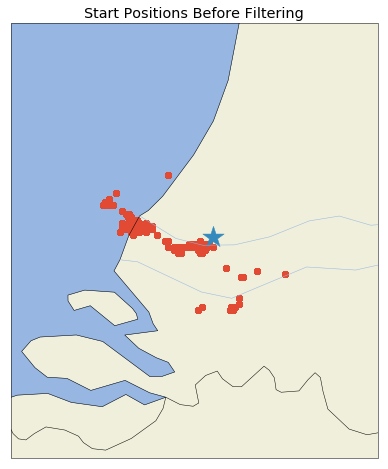

In [13]:
# Plot start positions before any filtering to map
plot_to_map(size = (8, 8), longitude = ais['StartLongitude'], latitude = ais['StartLatitude'])
plt.title("Start Positions Before Filtering")

Text(0.5,1,u'End Positions Before Filtering')

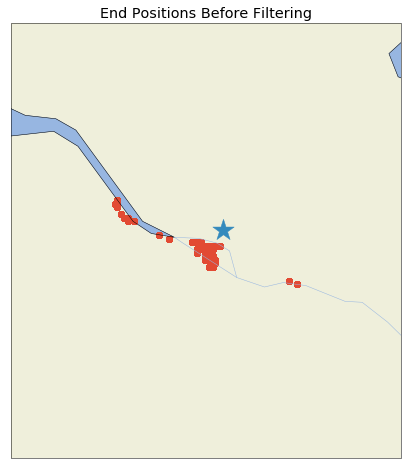

In [14]:
# Plot end positions before any filtering to map
plot_to_map(size = (8, 8), longitude = ais['EndLongitude'], latitude = ais['EndLatitude'])
plt.title("End Positions Before Filtering")

Text(0.5,1,u'Trip 21109')

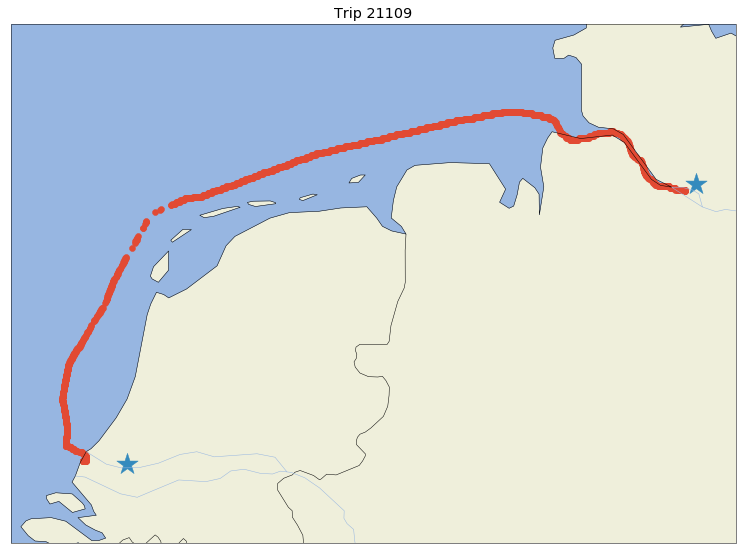

In [15]:
# Plot trip 21109 just for fun
posis = ais[ais['TripID'] == '21109'][['Latitude', 'Longitude']]
plot_to_map(size = (13, 13), latitude = posis['Latitude'], longitude = posis['Longitude'])
plt.title("Trip 21109")

In [16]:
# Get rid of trips that leave our zone (2.45 - 10.66 / 51.49 - 55.06)

outside_long_mask = (ais['Longitude'] < 2.45) | (ais['Longitude'] > 10.66)
outside_lat_mask = (ais['Latitude'] < 51.49) | (ais['Latitude'] > 55.06)

outside_rec_mask = outside_long_mask | outside_lat_mask

outside_trip_ids = ais['TripID'][outside_rec_mask].unique()
outside_trip_mask = ~ais['TripID'].isin(outside_trip_ids)
ais = ais[outside_trip_mask]

Text(0.5,1,u'All Positions After Filtering to Our Zone')

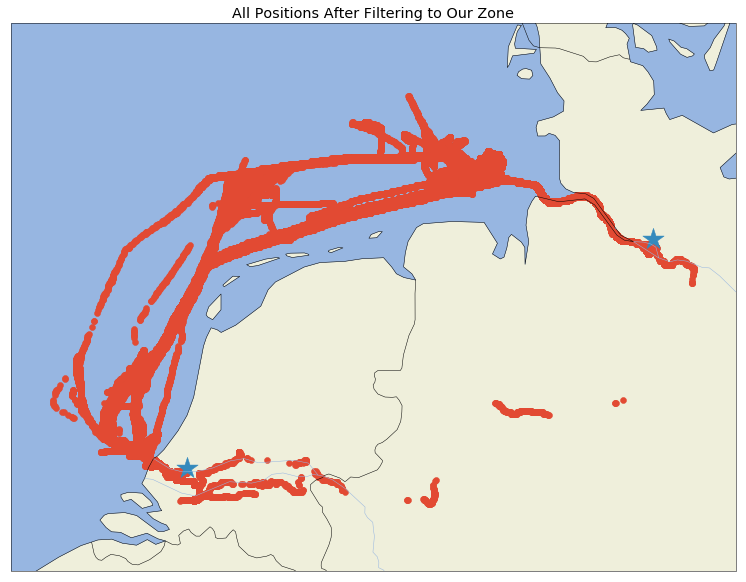

In [17]:
plot_to_map(size = (13, 13), longitude = ais['Longitude'], latitude = ais['Latitude'])
plt.title("All Positions After Filtering to Our Zone")

In [18]:
# See how many EndTimes deviate badly from the max timestamp the trip has
max_times = ais.groupby('TripID')['time'].max()
end_times = ais.groupby('TripID')['EndTime'].max()

diffs = end_times - max_times
big_diffs = diffs[diffs > pd.Timedelta('1 h')]
big_diffs.describe()

count                        72
mean     1 days 16:27:29.166666
std      0 days 20:46:33.437908
min             0 days 04:36:00
25%             0 days 22:17:00
50%             1 days 16:07:00
75%             2 days 05:36:15
max             3 days 16:31:00
dtype: object

In [19]:
# Removed those trips where the EndTimes deviate badly from the max timestamp the trip has
ais = ais[~ais['TripID'].isin(big_diffs.index)]

In [20]:
# Add time for the entire trip to the data
ais['TravelTime'] = ais['EndTime'] - ais['StartTime']

In [21]:
# Get and plot the longest trip in the data set
longest_trip = ais[ais['TravelTime'] == ais['TravelTime'].max()]
longest_trip.head()

,TripID,StartLatitude,StartLongitude,StartTime,EndLatitude,EndLongitude,EndTime,time,Length,Breadth,Draught,Latitude,Longitude,SOG,COG,TH,Destination,Callsign,TravelTime
ID,,,,,,,,,,,,,,,,,,,
55814921,232230,51.88,4.27,2016-01-25 23:33:00,53.5,9.96,2016-02-05 15:28:00,2016-01-25 23:33:00,155.0,24,7.08,51.88,4.27,3.6,140.0,120.0,ROTTERDAM,HBLY,10 days 15:55:00
55815994,232230,51.88,4.27,2016-01-25 23:33:00,53.5,9.96,2016-02-05 15:28:00,2016-01-25 23:34:00,155.0,24,7.08,51.88,4.27,3.5,120.0,94.0,ROTTERDAM,HBLY,10 days 15:55:00
55816508,232230,51.88,4.27,2016-01-25 23:33:00,53.5,9.96,2016-02-05 15:28:00,2016-01-25 23:35:00,155.0,24,7.08,51.88,4.27,3.3,91.0,80.0,ROTTERDAM,HBLY,10 days 15:55:00
55817411,232230,51.88,4.27,2016-01-25 23:33:00,53.5,9.96,2016-02-05 15:28:00,2016-01-25 23:36:00,155.0,24,7.08,51.88,4.28,3.6,80.0,79.0,ROTTERDAM,HBLY,10 days 15:55:00
55817846,232230,51.88,4.27,2016-01-25 23:33:00,53.5,9.96,2016-02-05 15:28:00,2016-01-25 23:37:00,155.0,24,7.08,51.88,4.28,3.8,79.0,78.0,ROTTERDAM,HBLY,10 days 15:55:00


Text(0.5,1,u'Longest Trip in the Data Set')

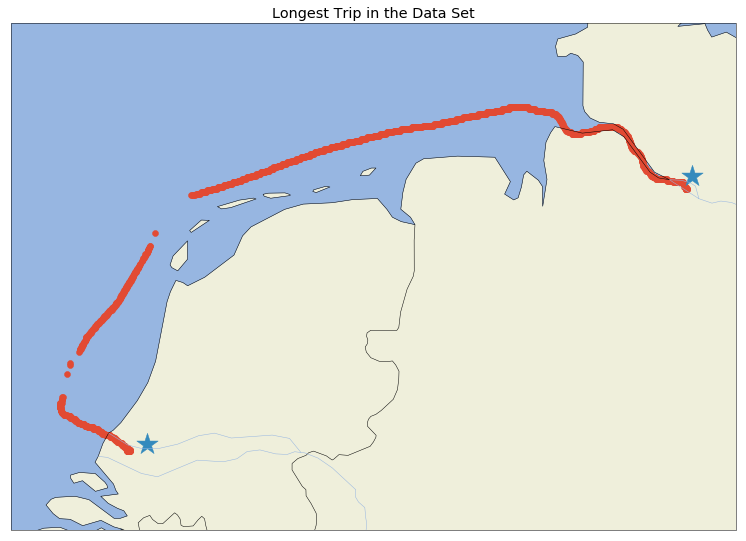

In [22]:
plot_to_map(size = (13, 13), longitude = longest_trip['Longitude'], latitude = longest_trip['Latitude'])
plt.title("Longest Trip in the Data Set")

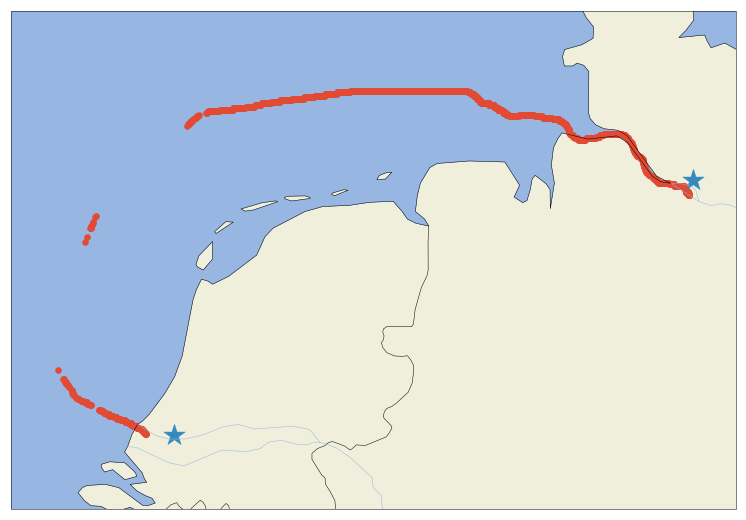

In [23]:
# Holidaymaker from our Weka filtering plottet
holidaymaker = ais[ais['TripID'] == '834747']
plot_to_map(size = (13, 13), longitude = holidaymaker['Longitude'], latitude = holidaymaker['Latitude'])

Text(0.5,1,u"Ursula's Shortest Trip")

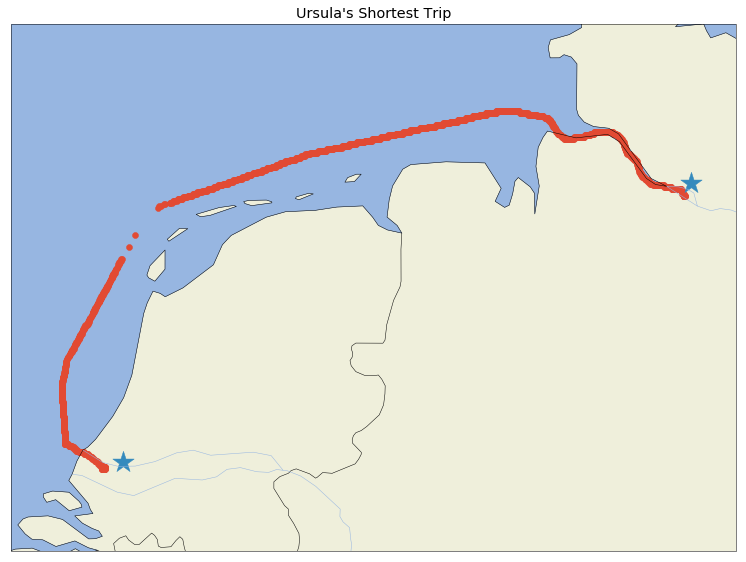

In [24]:
ursulas_trips = ais[ais['Callsign'] == '3FDB8']
ursulas_shortest = ursulas_trips[ursulas_trips['TravelTime'] == ursulas_trips['TravelTime'].min()]
plot_to_map(size = (13, 13), longitude = ursulas_shortest['Longitude'], latitude = ursulas_shortest['Latitude'])
plt.title("Ursula's Shortest Trip")

In [25]:
ais['TravelTime'].describe()

count                   1101977
mean     1 days 08:37:49.340358
std      1 days 01:01:36.775541
min             0 days 16:59:00
25%             0 days 21:56:00
50%             1 days 01:42:00
75%             1 days 08:21:00
max            10 days 15:55:00
Name: TravelTime, dtype: object

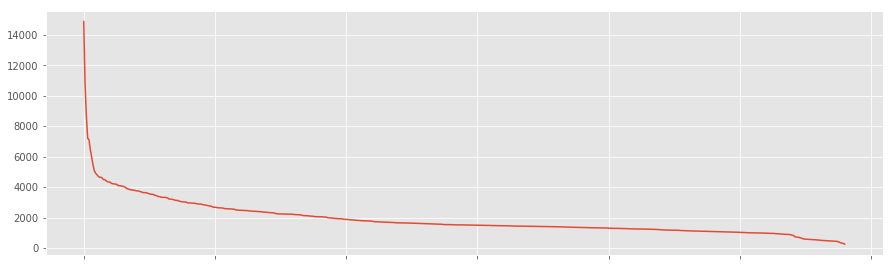

In [26]:
plt.figure(figsize = (15, 5))
ais['TravelTime'].value_counts().plot()

In [27]:
short_trip_mask = ais['TravelTime'] < pd.Timedelta('1 days')
ais = ais[short_trip_mask]
ais['TravelTime'].describe()

count                    447570
mean     0 days 21:21:10.354715
std      0 days 01:36:45.089841
min             0 days 16:59:00
25%             0 days 20:14:00
50%             0 days 21:33:00
75%             0 days 22:41:00
max             0 days 23:59:00
Name: TravelTime, dtype: object

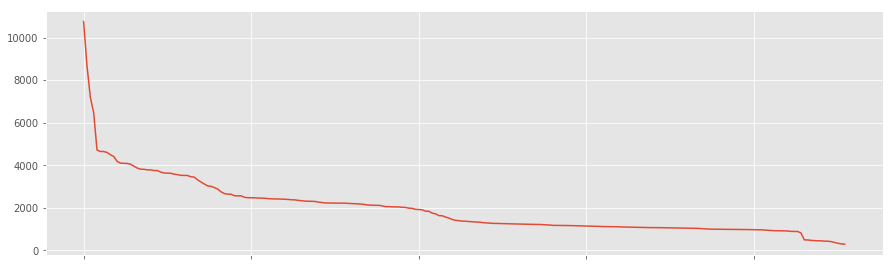

In [28]:
plt.figure(figsize = (15, 5))
ais['TravelTime'].value_counts().plot()

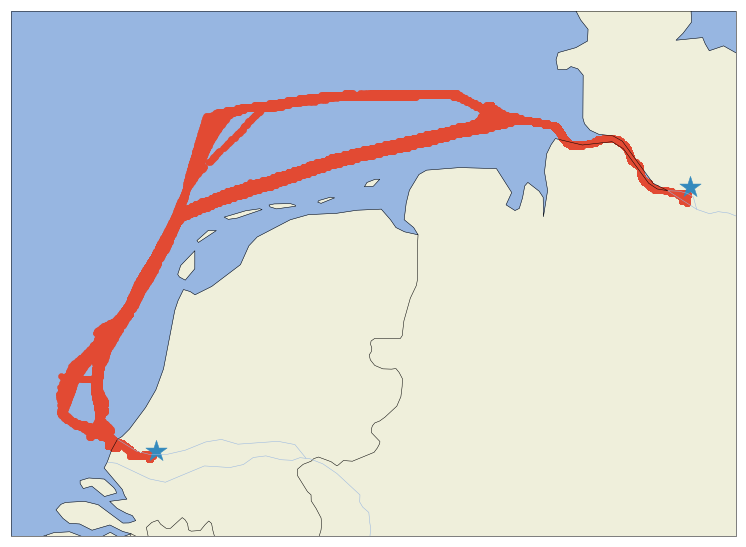

In [29]:
plot_to_map(size = (13, 13), longitude = ais['Longitude'], latitude = ais['Latitude'])

In [30]:
ais['TripID'].describe()

count     447570
unique       400
top       922076
freq        3957
Name: TripID, dtype: object

In [31]:
ais.groupby('TripID').max()['Callsign'].describe()

count       400
unique      180
top       V2PM7
freq         12
Name: Callsign, dtype: object